Aim of this paper is to predict values for some of India's stan, so I will combine features' values form each city to get mean features' value for that stan. Thanks to this approch I will be able to reduce number of rows therefore time reduction for training machine learning algoritms and most importantlly I will reduce number of missing values. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

$\textbf{Data Import}$

In [2]:
df = pd.read_csv('../Data_for_Imputation/Dataframe_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
col_to_impute = df.columns.to_list()
col_to_impute.remove('city')
df.head(2)

,PM10 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Temp (degree C),RH (%),WS (m/s),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C),city,WD (degree)
datetime,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,39.0,32.33,7.07,6.6,0.48,14.5,1.0,4.63,33.43,71.67,2.3,123.67,NaN,-0.1,0.1,0.0,23.05,Tirupati,226.33
2016-07-01 11:00:00,39.0,35.80,7.40,NaN,0.49,15.0,0.7,4.50,33.70,70.00,2.5,186.00,NaN,-0.1,0.1,0.0,NaN,Tirupati,223.00


For visualization of imputation I will use Temp (degree C) feature

In [3]:
def imputation_result_plot(df_imputed: pd.DataFrame, df: pd.DataFrame, title: str):
    """
    Plot the comparison between imputed data and original data for a specific feature and city.

    Parameters:
    df_imputed (pd.DataFrame): DataFrame containing imputed data.
    df (pd.DataFrame): Original DataFrame containing data before imputation.
    title (str): Title for the plot.

    Returns:
    None
    """
    
    # Define feature, city, and date for comparison
    feature = 'Temp (degree C)'
    city = 'Tirupati'
    date = '2018-06'
    
    # Filter indexes for the specified date
    indexes = df.index.strftime('%Y-%m') == date

    # Select data for comparison from both imputed and original DataFrames
    df_imputed_to_compare = df_imputed[indexes]
    df_imputed_to_compare = df_imputed_to_compare[df_imputed_to_compare['city'] == city][feature]

    df_to_compare = df[indexes]
    df_to_compare = df_to_compare[df_to_compare['city'] == city][feature]

    # Create a new figure for the plot
    plt.figure(figsize=(15, 8))

    # Plot the main line with markers for original data
    df_to_compare.plot(style='-', title=f'{feature} - {title}', label= 'imported dataframe')

    # Add points where data was imputed with red color
    plt.scatter(
        x=df_to_compare[df_to_compare.isna()].index,
        y=df_imputed_to_compare[df_to_compare.isna()],
        label = 'imputed values',
        color='red',
        marker='.'
    )

    # Set labels for x-axis, y-axis, and title
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()

    # Display the plot
    plt.show()

$\textbf{Data Imputation}$

First -> Last Observation Carried Forward (LOCF)

In [4]:
df_imputed = df.copy()
cities = df['city'].unique()
for city in cities:
    df_imputed.loc[df_imputed['city'] == city, col_to_impute] = df.loc[df_imputed['city'] == city, col_to_impute].fillna(method="ffill")

df_to_save = df_imputed.groupby(pd.Grouper(freq='1H')).mean(numeric_only= True).round(4)
df_to_save.to_csv('../Data_for_ML/LOCF_Andhra_Pradesh.csv', index= True)

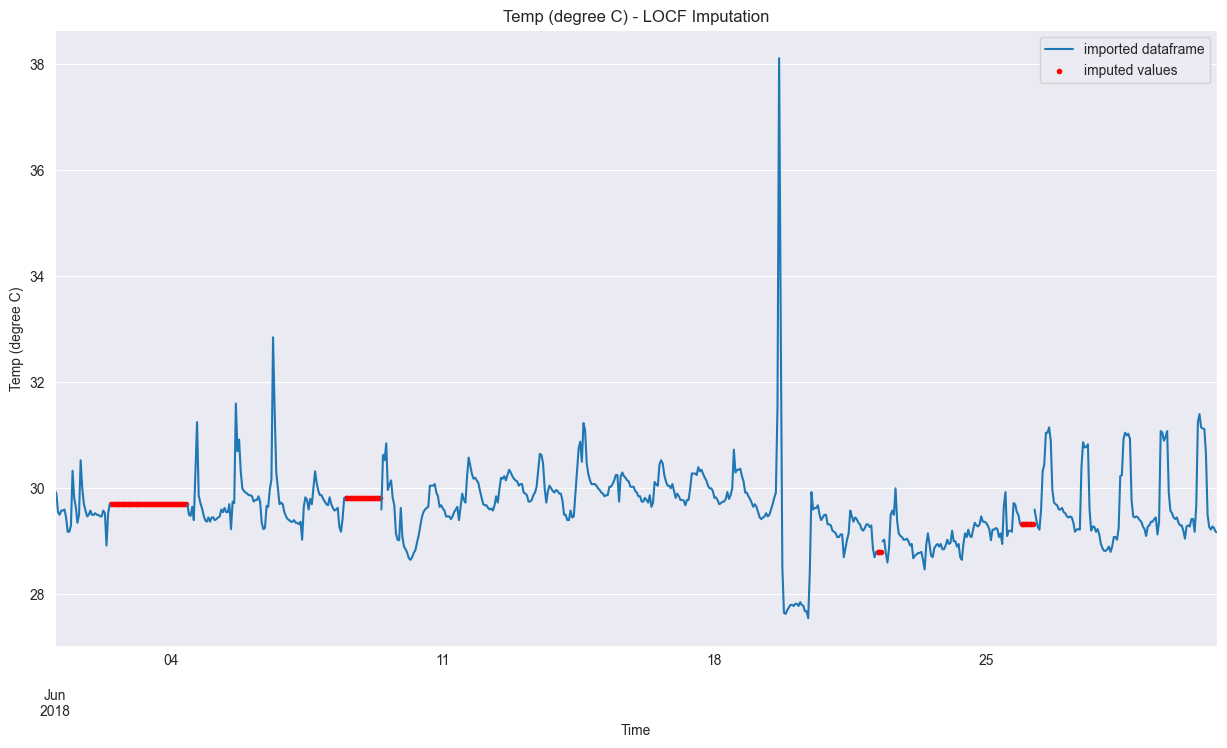

In [5]:
title = 'LOCF Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

kNN imputer

In [6]:
df_imputed = df.copy()

imp = KNNImputer(n_neighbors = 5)
filtred_data = df[col_to_impute]
df_imputed[col_to_impute] = imp.fit_transform(filtred_data)

df_to_save = df_imputed.groupby(pd.Grouper(freq='1H')).mean(numeric_only= True).round(4)
df_to_save.to_csv('../Data_for_ML/kNN_Andhra_Pradesh.csv', index= True)

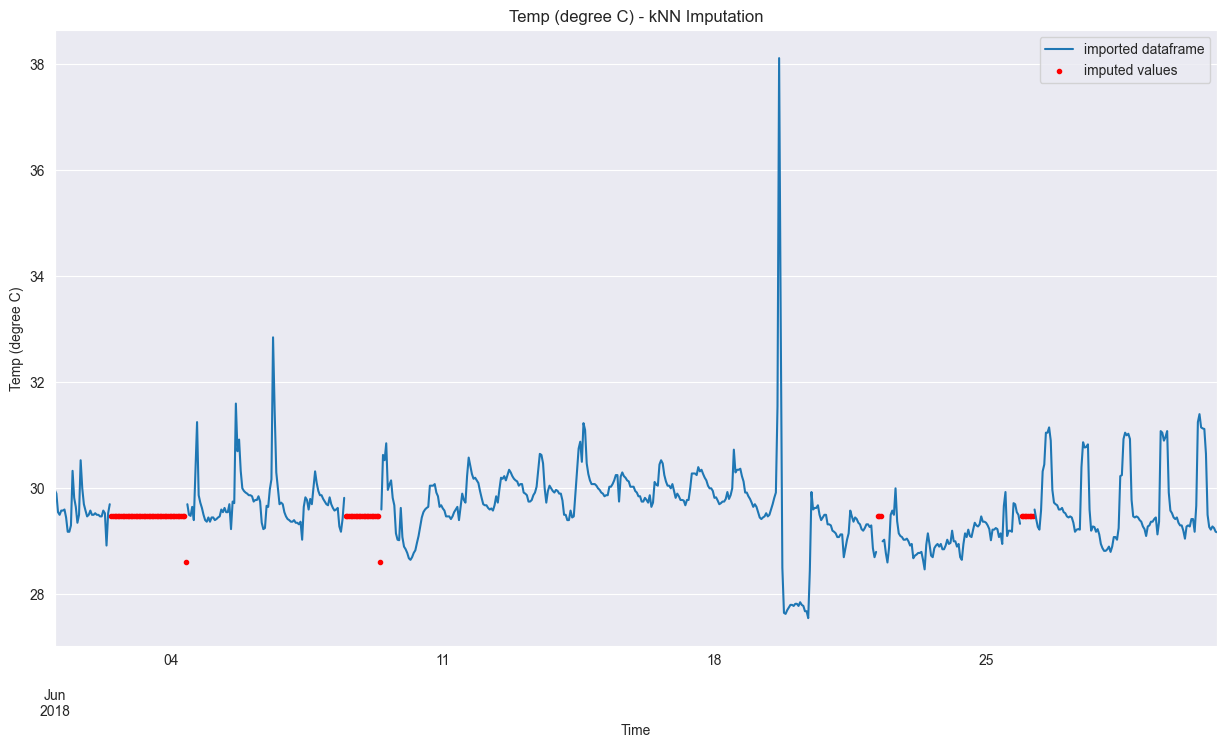

In [7]:
title = 'kNN Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

Mean - Imputation

In [8]:
df_imputed = df.copy()
cities = df['city'].unique()

for city in cities:
    imp = SimpleImputer(strategy= "mean")
    filtred_data = df.loc[df_imputed['city'] == city, col_to_impute]
    try:
        df_imputed.loc[df_imputed['city'] == city, col_to_impute] = imp.fit_transform(filtred_data)
    except:
        pass

imp = SimpleImputer(strategy= "mean")
df_imputed[col_to_impute] = imp.fit_transform(df_imputed[col_to_impute])

df_to_save = df_imputed.groupby(pd.Grouper(freq='1H')).mean(numeric_only= True).round(4)
df_to_save.to_csv('../Data_for_ML/Mean_Andhra_Pradesh.csv', index= True)

a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


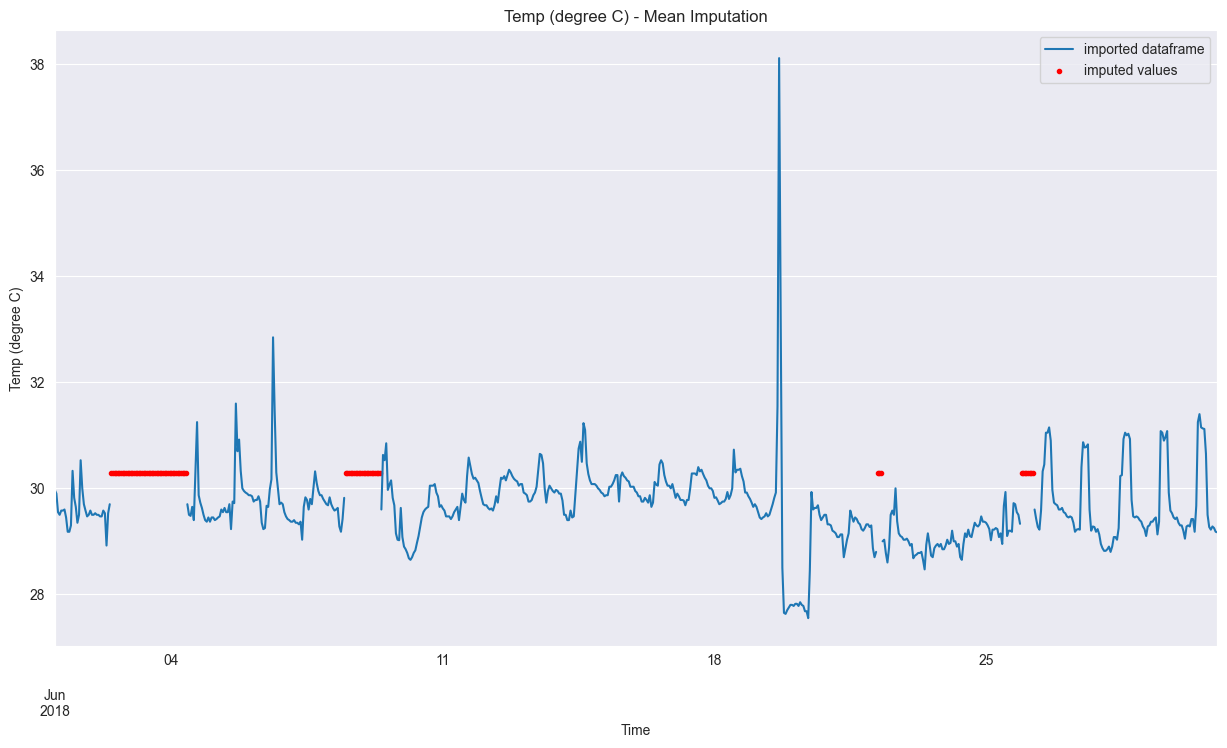

In [9]:
title = 'Mean Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

Linear Interpolation

In [10]:
df_imputed = df.copy()
cities = df['city'].unique()

# Apply the spline interpolation method

for city in cities:
    for col in col_to_impute:    
         filtred_data = df_imputed.loc[df_imputed['city'] == city, col]

         df_imputed.loc[df_imputed['city'] == city, col] = filtred_data.interpolate(method= "linear")
         df_imputed.loc[df_imputed['city'] == city, col]
        

df_to_save = df_imputed.groupby(pd.Grouper(freq='1H')).mean(numeric_only= True).round(4)
df_to_save.to_csv('../Data_for_ML/Linear_interpolation_Andhra_Pradesh.csv', index= True)

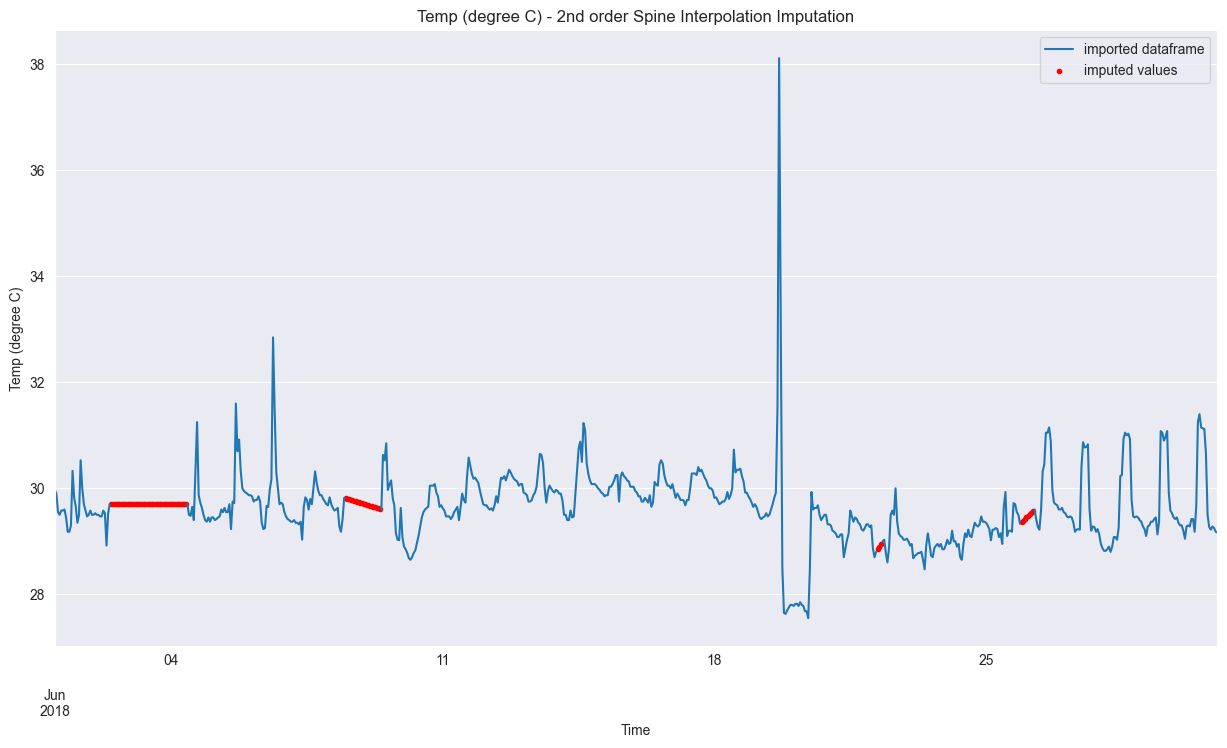

In [11]:
title = '2nd order Spine Interpolation Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)